In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_theme()
sns.set_style("dark")

## Load extracted features

In [2]:
data_basepath = './n96ncsr5g4-1'
url_features_path = './url_features.json'
html_features_path = './html_features.json'

In [3]:
with open(url_features_path) as f:
    url_features = json.load(f)
    
with open(html_features_path) as f:
    html_features = json.load(f)

In [4]:
features = {}
for k in url_features.keys():
    url_feat = url_features[k]
    html_feat = html_features[k]
    
    url_feat.update(html_feat)
    features[k] = url_feat

In [5]:
df = pd.DataFrame.from_dict(features, orient='index')
df.head()

,label,url_length,num_subdomains,uses_https,contains_ip,contains_phishing_keywords,contains_at_symbol,url_depth,is_shortened_url,is_punycode,...,login_form_present,javascript_redirects_present,iframes_count,num_obfuscated_scripts,external_js_inclusion,num_inline_styles,num_script_tags,num_iframe_tags,num_img_tags,num_a_tags
1,1,34,2,False,False,False,False,3,False,False,...,False,False,0,0,False,8,1,0,4,1
2,0,40,3,True,False,False,False,2,False,False,...,False,False,0,0,False,4,4,0,2,7
3,0,48,3,True,False,False,False,3,False,False,...,False,False,0,0,True,3,8,0,5,77
4,0,52,3,True,False,False,False,4,False,False,...,False,False,1,0,False,10,6,1,19,150
5,0,33,4,True,False,False,False,2,False,False,...,False,False,1,1,True,5,17,1,12,58


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 1 to 80000
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   label                         80000 non-null  int64
 1   url_length                    80000 non-null  int64
 2   num_subdomains                80000 non-null  int64
 3   uses_https                    80000 non-null  bool 
 4   contains_ip                   80000 non-null  bool 
 5   contains_phishing_keywords    80000 non-null  bool 
 6   contains_at_symbol            80000 non-null  bool 
 7   url_depth                     80000 non-null  int64
 8   is_shortened_url              80000 non-null  bool 
 9   is_punycode                   80000 non-null  bool 
 10  has_redirection               80000 non-null  bool 
 11  is_domain_valid               80000 non-null  bool 
 12  days_until_expiration         80000 non-null  int64
 13  registration_length           80000 

## Check for missing values

In [7]:
df.isnull().sum()

label                           0
url_length                      0
num_subdomains                  0
uses_https                      0
contains_ip                     0
contains_phishing_keywords      0
contains_at_symbol              0
url_depth                       0
is_shortened_url                0
is_punycode                     0
has_redirection                 0
is_domain_valid                 0
days_until_expiration           0
registration_length             0
num_forms                       0
num_username_fields             0
num_password_fields             0
num_hidden_fields               0
form_action                     0
form_autocomplete               0
external_links_count            0
login_form_present              0
javascript_redirects_present    0
iframes_count                   0
num_obfuscated_scripts          0
external_js_inclusion           0
num_inline_styles               0
num_script_tags                 0
num_iframe_tags                 0
num_img_tags  

## Convert categorical features to one-hot

In [8]:
dummy_feats = pd.get_dummies(df['form_action'], drop_first=True, prefix='form_action')
df = pd.concat([df.drop('form_action', axis=1), dummy_feats], axis=1)
df.head()

,label,url_length,num_subdomains,uses_https,contains_ip,contains_phishing_keywords,contains_at_symbol,url_depth,is_shortened_url,is_punycode,...,num_obfuscated_scripts,external_js_inclusion,num_inline_styles,num_script_tags,num_iframe_tags,num_img_tags,num_a_tags,form_action_1,form_action_2,form_action_3
1,1,34,2,False,False,False,False,3,False,False,...,0,False,8,1,0,4,1,0,0,1
2,0,40,3,True,False,False,False,2,False,False,...,0,False,4,4,0,2,7,0,1,0
3,0,48,3,True,False,False,False,3,False,False,...,0,True,3,8,0,5,77,1,0,0
4,0,52,3,True,False,False,False,4,False,False,...,0,False,10,6,1,19,150,0,1,0
5,0,33,4,True,False,False,False,2,False,False,...,1,True,5,17,1,12,58,0,0,1


## Split into training and test set

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('label', axis=1).to_numpy().astype(float)
y = df['label'].to_numpy()

test_size = 0.2
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=seed)
print(f'Number of training samples: {X_train.shape}')
print(f'Number of test samples: {X_test.shape}')

Number of training samples: (64000, 32)
Number of test samples: (16000, 32)


In [10]:
def plot_class_distribution(y, ax, title):
    labels, counts = np.unique(y, return_counts=True)

    ax.bar(labels, counts, align='center')
    ax.set_xticks([0, 1], ['legitimate', 'phishing'], rotation=45, ha='right')
    ax.set_title(title)

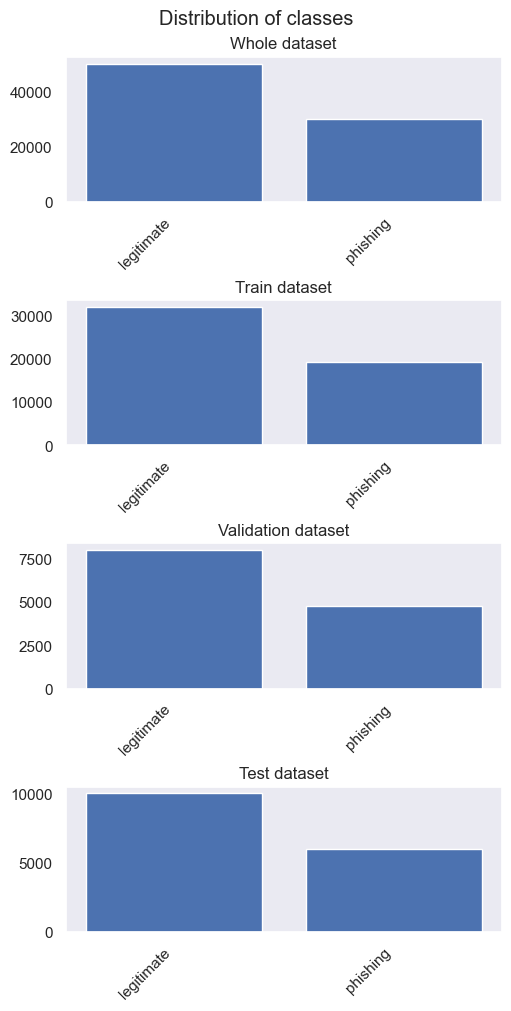

In [11]:
fig = plt.figure(figsize=(5, 10), constrained_layout=True)
gs = fig.add_gridspec(4, 1)

ax = fig.add_subplot(gs[0, 0])
plot_class_distribution(y, ax, title='Whole dataset')

ax = fig.add_subplot(gs[1, 0])
plot_class_distribution(y_train[12800:], ax, title='Train dataset')

ax = fig.add_subplot(gs[2, 0])
plot_class_distribution(y_train[:12800], ax, title='Validation dataset')

ax = fig.add_subplot(gs[3, 0])
plot_class_distribution(y_test, ax, title='Test dataset')


plt.suptitle('Distribution of classes')
plt.show()
plt.close()

## Normalize continuous features and performa PCA analysis

In [12]:
def plot_pca(X_pca, y, n_components):
    X_list = [X_pca[:, i] for i in range(n_components)]
    
    if len(X_list) == 3:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes() 
    ax.scatter(*X_list, c=y, cmap='RdYlBu')
    ax.set_title(f'Distribution of data using PCA with {n_components = }')
    plt.show()
    plt.close()

In [13]:
cont_feats = {
    "url_length",
    "url_depth",
    "days_until_expiration",
    "registration_length",
    "num_forms",
    "num_username_fields",
    "num_password_fields",
    "num_hidden_fields",
    "form_autocomplete",
    "external_links_count",
    "iframes_count",
    "num_obfuscated_scripts",
    "num_inline_styles",
    "num_script_tags",
    "num_iframe_tags",
    "num_img_tags",
    "num_a_tags",
  }
columns = df.columns[1:]
cont_ids = [i for i, c in enumerate(columns) if c in cont_feats]


mean = X_train[:, cont_ids].mean(axis=0, keepdims=True)
std = X_train[:, cont_ids].std(axis=0, keepdims=True)
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()
X_train_norm[:, cont_ids] = (X_train[:, cont_ids] - mean) / std
X_test_norm[:, cont_ids] = (X_test[:, cont_ids] - mean) / std

In [14]:
X_train[:, cont_ids]

array([[ 58.,   3.,  -1., ...,   3.,  31., 214.],
       [ 82.,   3.,  -1., ...,   0.,   0.,   0.],
       [ 42.,   3.,  62., ...,   0.,   3., 156.],
       ...,
       [ 50.,   2.,  -1., ...,   1.,   8.,  15.],
       [ 34.,   1.,  -1., ...,   0.,   0., 106.],
       [ 38.,   2., 813., ...,   0.,   0.,  23.]])

In [15]:
np.round(X_train_norm[:, cont_ids] * 100) / 100

array([[-0.11, -0.24, -0.52, ...,  2.36,  0.15,  0.14],
       [ 0.35, -0.24, -0.52, ..., -0.36, -0.15, -0.13],
       [-0.42, -0.24, -0.43, ..., -0.36, -0.12,  0.07],
       ...,
       [-0.27, -0.86, -0.52, ...,  0.55, -0.07, -0.12],
       [-0.57, -1.48, -0.52, ..., -0.36, -0.15,  0.  ],
       [-0.5 , -0.86,  0.65, ..., -0.36, -0.15, -0.1 ]])

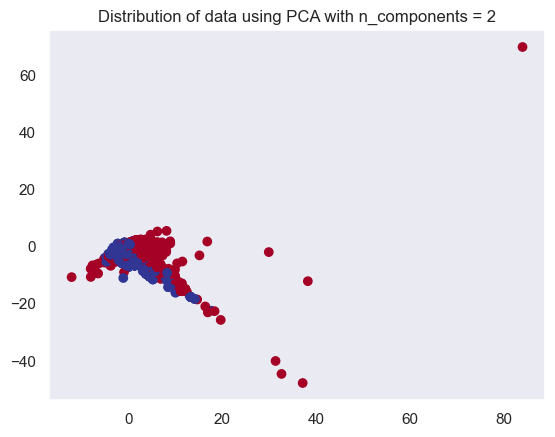

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_norm)
X_train_pca = pca.transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)
        
plot_pca(X_train_pca, y_train, n_components=2)

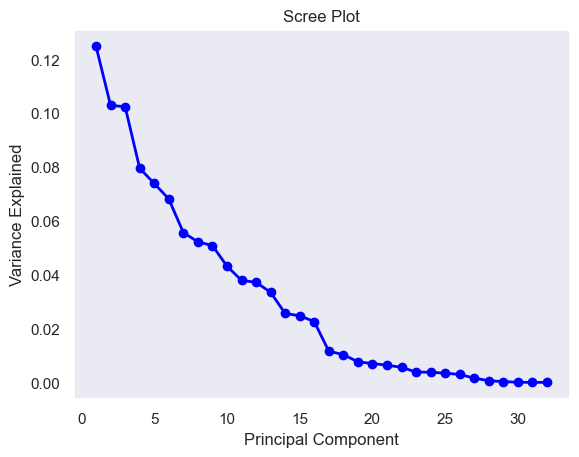

In [17]:
x_ticks = np.arange(pca.n_components_) + 1
plt.plot(x_ticks, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

## Data augmentation using SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_norm, y_train)

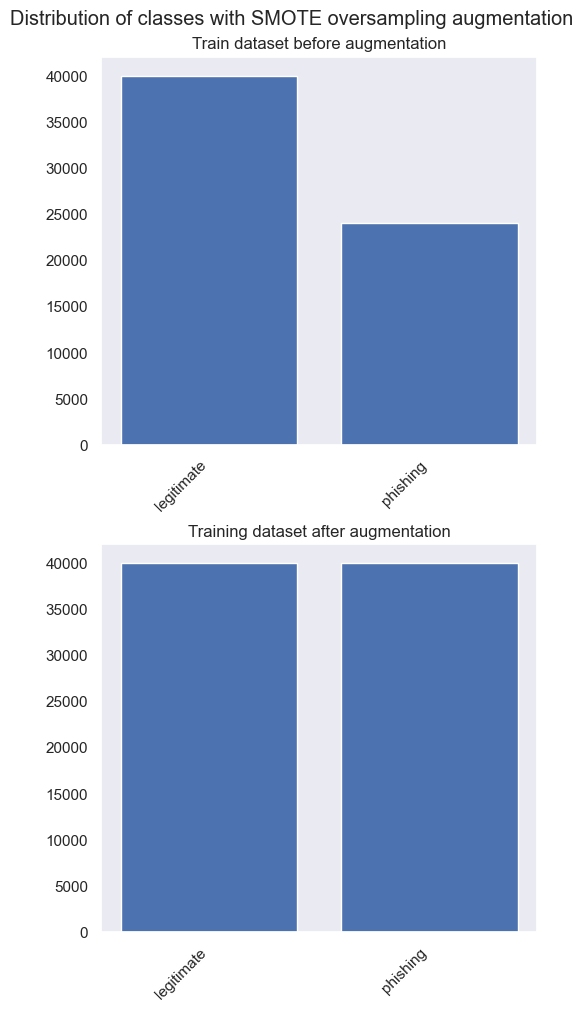

In [19]:
fig = plt.figure(figsize=(5, 10), constrained_layout=True)
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0, 0])
plot_class_distribution(y_train, ax, title='Train dataset before augmentation')

ax = fig.add_subplot(gs[1, 0])
plot_class_distribution(y_res, ax, title='Training dataset after augmentation')

plt.suptitle('Distribution of classes with SMOTE oversampling augmentation')
plt.show()
plt.close()

## Metrics

In [20]:
from sklearn import metrics

def compute_model_metrics(model, X, y_true):
    y_pred = model.predict(X)
    
    print("Confusion Matrix")
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    ax = sns.heatmap(confusion_matrix, cmap="Blues",  annot=True, fmt="d", linewidths=.1)
    xticks = [i + 0.5 for i in range(2)]
    ax.set_xticks(
        xticks, ['legitimate', 'phishing'], rotation=45, ha='right'
    )
    ax.set_yticks(
        xticks, ['legitimate', 'phishing'], rotation=0, va='top'
    )
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    plt.show()

    report = metrics.classification_report(
        y_true, y_pred, target_names=['legitimate', 'phishing'], digits=4
    )
    print(report)
    test_acc = metrics.accuracy_score(y_true, y_pred)
    print(f'Accuracy: {test_acc:.4f}')
    
    test_precision = metrics.precision_score(y_true, y_pred, average='micro')
    print(f'Micro Precision: {test_precision:.4f}')
        
    test_recall = metrics.recall_score(y_true, y_pred, average='micro')
    print(f'Micro Recall/TPR: {test_recall:.4f}')
    
    test_f1 = metrics.f1_score(y_true, y_pred, average='micro')
    print(f'Micro f1-score: {test_f1:.4f}')

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
import numpy as np

# Grid search.
parameters = [
	{"kernel": ["linear"], "C": [10000]},
	{"kernel": ["poly"], "degree": [2, 3, 4], "C": np.logspace(-1, 3, 4)},
	{"kernel": ["rbf"], "gamma": [0.1, 0.01, 0.001], "C": np.logspace(-1, 3, 4),}
]


grid_search = GridSearchCV(
    SVC(), parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=16, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

**Fit with the best parameters**

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(C=1000, gamma=0.01, kernel='rbf')
svm_clf.fit(X_train_norm, y_train)

SVC(C=1000, gamma=0.01)

        SVM Model Metrics       

Confusion Matrix


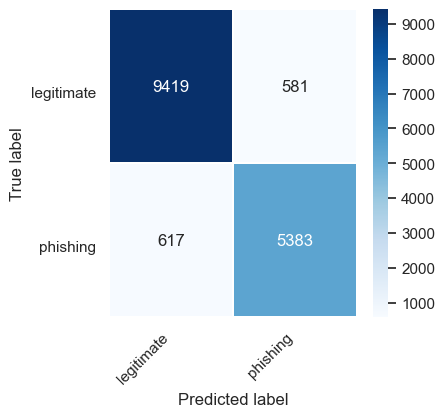

              precision    recall  f1-score   support

  legitimate     0.9385    0.9419    0.9402     10000
    phishing     0.9026    0.8972    0.8999      6000

    accuracy                         0.9251     16000
   macro avg     0.9206    0.9195    0.9200     16000
weighted avg     0.9250    0.9251    0.9251     16000

Accuracy: 0.9251
Micro Precision: 0.9251
Micro Recall/TPR: 0.9251
Micro f1-score: 0.9251


In [20]:
print("        SVM Model Metrics       \n")
compute_model_metrics(svm_clf, X_test_norm, y_test)

## Decision Tree

In [ ]:
# Define the parameter grid for GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

dt_parameters = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "ccp_alpha": [0.0, 0.001, 0.01, 0.1, 1.0]
}

dt_simple = DecisionTreeClassifier(random_state=123)

# Create a scorer for GridSearchCV
scorer = make_scorer(accuracy_score)

# Perform grid search with cross-validation on the subset
dt_grid_search = GridSearchCV(
    dt_simple,
    dt_parameters,
    scoring=scorer,
    cv=5,
    n_jobs=5,
    return_train_score=True,
)

dt_grid_search.fit(X_train_norm, y_train)

# Display the best parameters and corresponding accuracy on the subset
print(f'Best parameters : {dt_grid_search.best_params_}')
print(f'Best training accuracy with cross-validation : {dt_grid_search.best_score_}')


**Fit with the best model**

Pruned Decision Tree - Cost-complexity pruning 

In [21]:
import time 
from sklearn.tree import DecisionTreeClassifier

start_time_pruned = time.time()

# Creating a new decision tree with the best parameters, including ccp_alpha for pruning
dt_pruned = DecisionTreeClassifier(
    random_state=123,
    ccp_alpha=0.0,
    criterion='entropy',
    max_depth= 20,
    min_samples_leaf=1,
    min_samples_split= 2
)

# Fitting the pruned decision tree on the full dataset
dt_pruned.fit(X_train_norm, y_train)

end_time_pruned = time.time()
time_taken_pruned = end_time_pruned - start_time_pruned


        Decision Tree Model Metrics       

Confusion Matrix


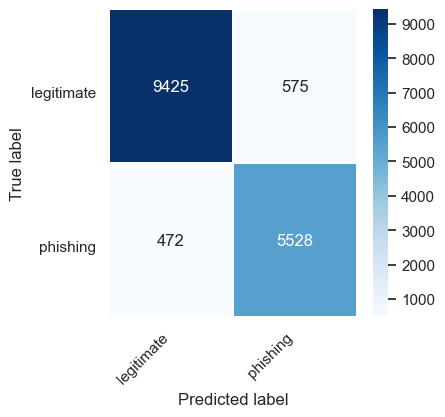

              precision    recall  f1-score   support

  legitimate     0.9523    0.9425    0.9474     10000
    phishing     0.9058    0.9213    0.9135      6000

    accuracy                         0.9346     16000
   macro avg     0.9290    0.9319    0.9304     16000
weighted avg     0.9349    0.9346    0.9347     16000

Accuracy: 0.9346
Micro Precision: 0.9346
Micro Recall/TPR: 0.9346
Micro f1-score: 0.9346


In [22]:
print("        Decision Tree Model Metrics       \n")
compute_model_metrics(dt_pruned, X_test_norm, y_test)

## Logistic Regression

In [19]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3, 3, 7),
    'solver'  : ['saga','lbfgs'],
}

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000), parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True,
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/shashank_tyag

Best training accuracy with 5-fold cross validation: 0.8823593750000001
Best parameters: 
{'C': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs'}


**Fit with best parameters**

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, penalty='l2', C=1000, solver='lbfgs')
log_reg.fit(X_train_norm, y_train)

LogisticRegression(C=1000, max_iter=1000)

        Logistic Regression Model Metrics       

Confusion Matrix


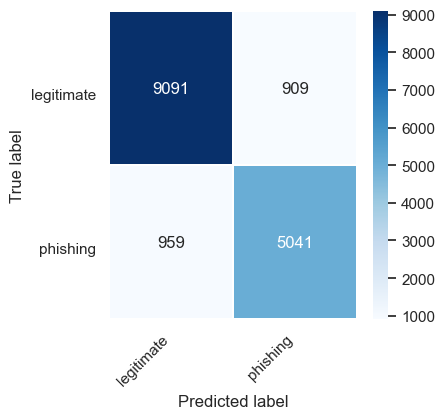

              precision    recall  f1-score   support

  legitimate     0.9046    0.9091    0.9068     10000
    phishing     0.8472    0.8402    0.8437      6000

    accuracy                         0.8833     16000
   macro avg     0.8759    0.8746    0.8753     16000
weighted avg     0.8831    0.8832    0.8832     16000

Accuracy: 0.8832
Micro Precision: 0.8832
Micro Recall/TPR: 0.8832
Micro f1-score: 0.8833


In [21]:
print("        Logistic Regression Model Metrics       \n")
compute_model_metrics(log_reg, X_test_norm, y_test)

## Random Forest

In [19]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

grid_space={
    'max_depth':[3,5,10,None],
    'n_estimators':[10,100,200],
    'max_features':[1,3,5,7],
    'min_samples_leaf':[1,2,3],
    'min_samples_split':[2,3]
}

grid_search = GridSearchCV(
    RandomForestClassifier(), grid_space, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
720 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/shashank_tyagi/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
 

Best training accuracy with 5-fold cross validation: 0.96075
Best parameters: 
{'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


**Fit with best parameters**

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    max_depth=None,
    n_estimators=200,
    max_features=3,
    min_samples_leaf=1,
    min_samples_split=3,
)

rf.fit(X_train_norm, y_train)

RandomForestClassifier(max_features=3, min_samples_split=3, n_estimators=200)

        Random Forest Model Metrics       

Confusion Matrix


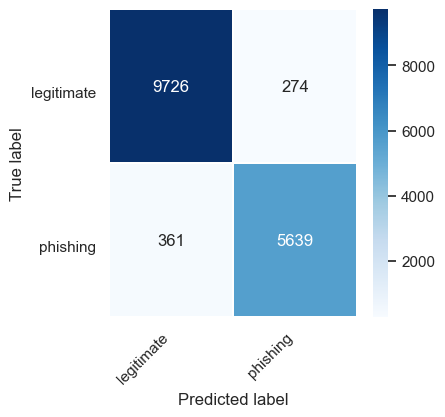

              precision    recall  f1-score   support

  legitimate     0.9642    0.9726    0.9684     10000
    phishing     0.9537    0.9398    0.9467      6000

    accuracy                         0.9603     16000
   macro avg     0.9589    0.9562    0.9575     16000
weighted avg     0.9603    0.9603    0.9603     16000

Accuracy: 0.9603
Micro Precision: 0.9603
Micro Recall/TPR: 0.9603
Micro f1-score: 0.9603


In [23]:
print("        Random Forest Model Metrics       \n")
compute_model_metrics(rf, X_test_norm, y_test)

## Performance with dimensionality reduction

In [19]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'SVM': SVC(C=1000, gamma=0.01, kernel='rbf'),
    'logistic_regression': LogisticRegression(
        penalty="l2",
        C=1e4,
        max_iter=1000
    ),
    'decision_tree': DecisionTreeClassifier(
        random_state=123,
        ccp_alpha=0.0,
        criterion='entropy',
        max_depth= 20,
        min_samples_leaf=1,
        min_samples_split= 2
    ),
    'random_forest': RandomForestClassifier(
        max_depth=None,
        n_estimators=200,
        max_features=3,
        min_samples_leaf=1,
        min_samples_split=3,
    )
}


In [23]:
from sklearn.preprocessing import StandardScaler

def test_with_pca_components(model, X_train_norm, y_train, X_test_norm, y_test, components_list):
    pca = PCA()
    pca.fit(X_train_norm)
    X_train_norm_pca = pca.transform(X_train_norm)
    X_test_norm_pca = pca.transform(X_test_norm)

    reports = []
    for n in components_list:
        model.fit(X_train_norm_pca[:, :n], y_train)
        y_test_pred = model.predict(X_test_norm_pca[:, :n])
        report = metrics.classification_report(
            y_test, y_test_pred, target_names=['legitimate', 'phishing'], digits=4, output_dict=True
        )
        reports.append(report)
        print(f'Testing for {n = }, acc: {report["accuracy"]}')

    return reports

In [24]:
components = [1, 2, 4, 10, 20, X_train_norm.shape[1]]

reports = {}
for name, model in models.items():
    print(f'Running {name}')
    reports[name] = test_with_pca_components(model, X_train_norm, y_train, X_test_norm, y_test, components)

Running SVM
Testing for n = 1, acc: report["accuracy"] = 0.811
Testing for n = 2, acc: report["accuracy"] = 0.826
Testing for n = 4, acc: report["accuracy"] = 0.8526875
Testing for n = 10, acc: report["accuracy"] = 0.883
Testing for n = 20, acc: report["accuracy"] = 0.9175625
Testing for n = 32, acc: report["accuracy"] = 0.925125
Running logistic_regression
Testing for n = 1, acc: report["accuracy"] = 0.8138125
Testing for n = 2, acc: report["accuracy"] = 0.816375
Testing for n = 4, acc: report["accuracy"] = 0.8466875
Testing for n = 10, acc: report["accuracy"] = 0.8584375
Testing for n = 20, acc: report["accuracy"] = 0.8751875
Testing for n = 32, acc: report["accuracy"] = 0.8833125
Running decision_tree
Testing for n = 1, acc: report["accuracy"] = 0.8054375
Testing for n = 2, acc: report["accuracy"] = 0.8566875
Testing for n = 4, acc: report["accuracy"] = 0.880875
Testing for n = 10, acc: report["accuracy"] = 0.9025
Testing for n = 20, acc: report["accuracy"] = 0.91275
Testing for n =

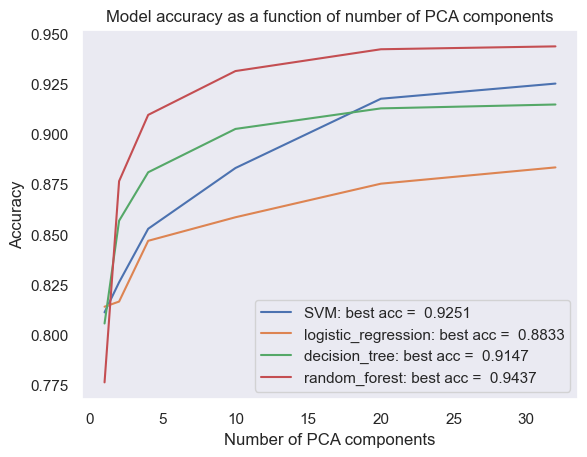

In [26]:
plt.figure()
for name, rep in reports.items():
    acc = [r['accuracy'] for r in rep]
    max_acc = max(acc)
    plt.plot(components, acc, label=f'{name}: best acc = {max_acc: .4f}')

plt.xlabel('Number of PCA components')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model accuracy as a function of number of PCA components')
plt.show()

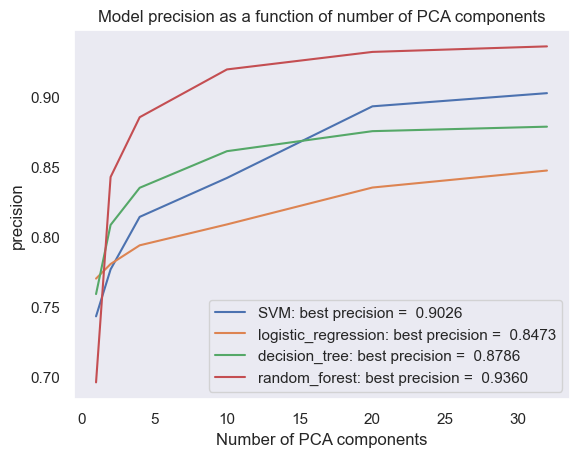

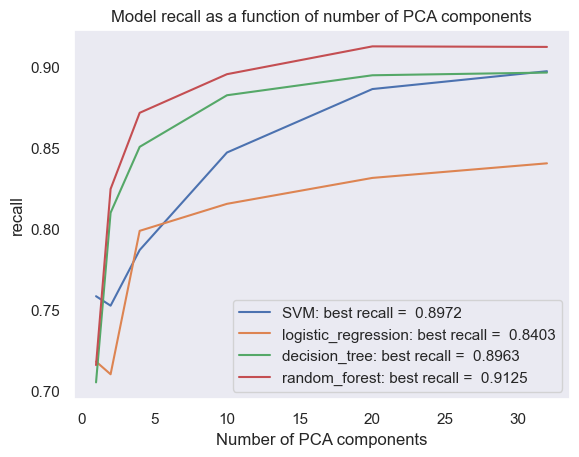

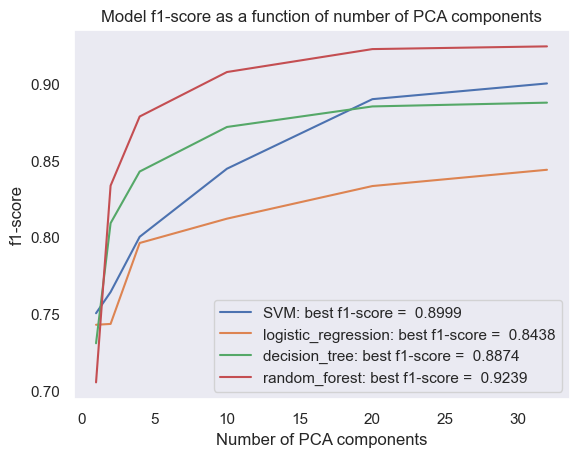

In [31]:
for metric_name in ['precision', 'recall', 'f1-score']:
    plt.figure()
    for name, rep in reports.items():
        metric = [r['phishing'][metric_name] for r in rep]
        best_metric = max(metric)
        plt.plot(components, metric, label=f'{name}: best {metric_name} = {best_metric: .4f}')
    
    plt.xlabel('Number of PCA components')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'Model {metric_name} as a function of number of PCA components')
    plt.show()

## Performance with oversampling

In [ ]:
reports = {}
for name, model in models.items():
    print(f'Running {name}')
    perfs = []
    for data in [(X_train_norm, y_train), (X_res, y_res)]:
        model.fit(data[0], data[1])
        y_test_pred = model.predict(X_test_norm)
        perfs.append(metrics.classification_report(
            y_test, y_test_pred, target_names=['legitimate', 'phishing'], digits=4, output_dict=True
        ))
    reports[name] = perfs

Running SVM


In [ ]:
reports

## Ensemble model

In [29]:
from sklearn.ensemble import VotingClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'SVM': SVC(C=1000, gamma=0.01, kernel='rbf'),
    'logistic_regression': LogisticRegression(
        penalty="l2",
        C=1e4,
        max_iter=1000
    ),
    'decision_tree': DecisionTreeClassifier(
        random_state=123,
        ccp_alpha=0.0,
        criterion='entropy',
        max_depth= 20,
        min_samples_leaf=1,
        min_samples_split= 2
    ),
    'random_forest': RandomForestClassifier(
        max_depth=None,
        n_estimators=200,
        max_features=3,
        min_samples_leaf=1,
        min_samples_split=3,
    )
}


In [30]:
ensemble_clf = VotingClassifier(estimators=[(k, v) for k, v in models.items()], n_jobs=2)
ensemble_clf.fit(X_train_norm, y_train)

VotingClassifier(estimators=[('logistic_regression',
                              LogisticRegression(C=10000.0, max_iter=1000)),
                             ('decision_tree',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=20,
                                                     random_state=123)),
                             ('random_forest',
                              RandomForestClassifier(max_features=3,
                                                     min_samples_split=3,
                                                     n_estimators=200))],
                 n_jobs=2)

Confusion Matrix


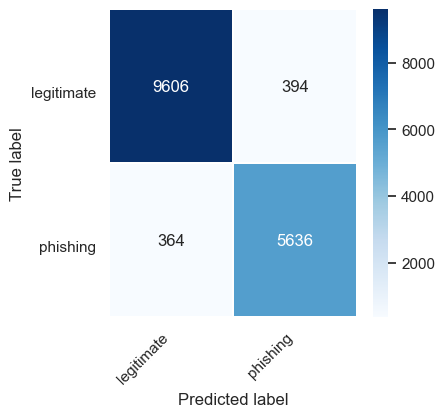

              precision    recall  f1-score   support

  legitimate     0.9635    0.9606    0.9620     10000
    phishing     0.9347    0.9393    0.9370      6000

    accuracy                         0.9526     16000
   macro avg     0.9491    0.9500    0.9495     16000
weighted avg     0.9527    0.9526    0.9526     16000

Accuracy: 0.9526
Micro Precision: 0.9526
Micro Recall/TPR: 0.9526
Micro f1-score: 0.9526


In [31]:
compute_model_metrics(ensemble_clf, X_test_norm, y_test)

In [27]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(hidden_layer_sizes=(64, 128, 256), random_state=1, max_iter=300, verbose=True)
mlp_clf.fit(X_train_norm, y_train)

Iteration 1, loss = 0.29050379
Iteration 2, loss = 0.22093245
Iteration 3, loss = 0.19973617
Iteration 4, loss = 0.18824917
Iteration 5, loss = 0.18132622
Iteration 6, loss = 0.17269980
Iteration 7, loss = 0.16782307
Iteration 8, loss = 0.16325004
Iteration 9, loss = 0.15941578
Iteration 10, loss = 0.15657603
Iteration 11, loss = 0.15013138
Iteration 12, loss = 0.14875122
Iteration 13, loss = 0.14525350
Iteration 14, loss = 0.14183539
Iteration 15, loss = 0.14048238
Iteration 16, loss = 0.13689125
Iteration 17, loss = 0.13449018
Iteration 18, loss = 0.13234427
Iteration 19, loss = 0.13089077
Iteration 20, loss = 0.12743447
Iteration 21, loss = 0.12598416
Iteration 22, loss = 0.12520861
Iteration 23, loss = 0.12249655
Iteration 24, loss = 0.11924175
Iteration 25, loss = 0.11678044
Iteration 26, loss = 0.11664075
Iteration 27, loss = 0.11315989
Iteration 28, loss = 0.11162220
Iteration 29, loss = 0.11113588
Iteration 30, loss = 0.10797952
Iteration 31, loss = 0.10566878
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(64, 128, 256), max_iter=300, random_state=1,
              verbose=True)

Confusion Matrix


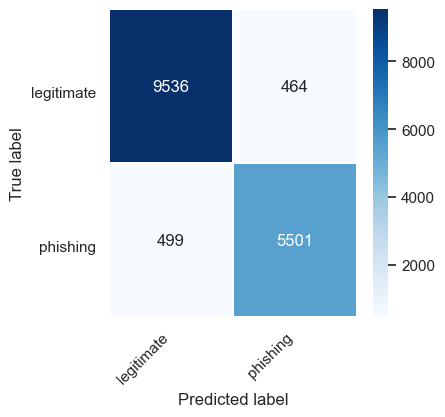

              precision    recall  f1-score   support

  legitimate     0.9503    0.9536    0.9519     10000
    phishing     0.9222    0.9168    0.9195      6000

    accuracy                         0.9398     16000
   macro avg     0.9362    0.9352    0.9357     16000
weighted avg     0.9398    0.9398    0.9398     16000

Accuracy: 0.9398
Micro Precision: 0.9398
Micro Recall/TPR: 0.9398
Micro f1-score: 0.9398


In [28]:
compute_model_metrics(mlp_clf, X_test_norm, y_test)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, make_scorer
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective='binary:logistic',
    nthread=4,
    seed=42,
)

parameters = {
    'max_depth': [16, 32, 64],
    'n_estimators': [100, 200, 400],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(
    xgb_clf, parameters, scoring=make_scorer(accuracy_score), cv=5, n_jobs=2, return_train_score=True
)
grid_search.fit(X_train_norm, y_train)
print(f'Best training accuracy with 5-fold cross validation: {grid_search.best_score_}')
print(f'Best parameters: \n{grid_search.best_params_}')

KeyboardInterrupt: 

In [63]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
        objective='binary:logistic',
        learning_rate=0.3,
        n_estimators=400,
        max_depth=32,
        min_child_weight=1,
        nthread=4,
        seed=42
)

xgb_clf.fit(X_train_norm, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=32, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, nthread=4, num_parallel_tree=None,
              predictor=None, ...)

Confusion Matrix


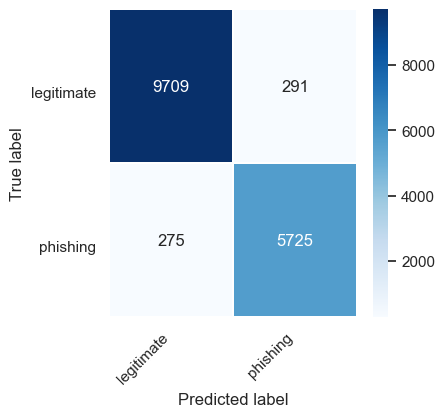

              precision    recall  f1-score   support

  legitimate     0.9725    0.9709    0.9717     10000
    phishing     0.9516    0.9542    0.9529      6000

    accuracy                         0.9646     16000
   macro avg     0.9620    0.9625    0.9623     16000
weighted avg     0.9646    0.9646    0.9646     16000

Accuracy: 0.9646
Micro Precision: 0.9646
Micro Recall/TPR: 0.9646
Micro f1-score: 0.9646


In [64]:
compute_model_metrics(xgb_clf, X_test_norm, y_test)